In [1]:
import numpy as np
import os

from qonnx.core.modelwrapper import ModelWrapper

from qonnx.custom_op.registry import getCustomOp

import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import finn.util.data_packing as dpk
from qonnx.core.datatype import DataType

In [2]:
from pathlib import Path
import cv2
import my_metrics as metrics
import matplotlib.pyplot as plt

### Template and Build folders

In [3]:
template_folder = './verilog_stitched_sim/templates'
build_folder = ('./experiments' 
               + '/400_FPS'
               + '/02_full_build_json_repeated_01'
               + '/output_full_build')
sim_output_dir = build_folder + "/sim"

if not os.path.isdir(sim_output_dir):
    print(f'Creating {sim_output_dir}')
    os.makedirs(sim_output_dir)

Creating ./experiments/400_FPS/02_full_build_json_repeated_01/output_full_build/sim


# Function to create Verilog sim file and tcl command to run the testbench

In [4]:
def make_verilog_simfile(templates_folder, build_folder):

    # Model and Stitched folder
    model_filename = build_folder + "/intermediate_models/step_create_stitched_ip.onnx"
    model = ModelWrapper(model_filename)
    vivado_stitched_folder = "../stitched_ip"
    
    # Simulation dir
    sim_output_dir = build_folder + "/sim"
    # Templates dir
    templates_dir = templates_folder
    
    # load the provided input data
    inp_data = np.load(sim_output_dir + "/input.npy")
    batchsize = inp_data.shape[0]
    
    # permute input image from NCHW -> NHWC format (needed by FINN)
    # No need to do this, as images will be loaded from cv2 as (N, H, W, C) -> (1, 224, 224, 3)
    # inp_data = np.transpose(inp_data, (0, 2, 3, 1))
    
    # ??? Intended for flattened FC networks... just to try
    #inp_data = inp_data.reshape(batchsize, -1)
    #print(f'Input data flattened: {inp_data}')
    
    # query the parallelism-dependent folded input shape from the
    # node consuming the graph input
    inp_name = model.graph.input[0].name
    inp_node = getCustomOp(model.find_consumer(inp_name))
    inp_shape_folded = list(inp_node.get_folded_input_shape())

    print(f'Input shape folded: {inp_shape_folded}')
    
    inp_stream_width = inp_node.get_instream_width_padded()
    
    print(f'Input stream width: {inp_stream_width}')
    
    # fix first dimension (N: batch size) to correspond to input data
    # since FINN model itself always uses N=1
    inp_shape_folded[0] = batchsize
    inp_shape_folded = tuple(inp_shape_folded)
    inp_dtype = model.get_tensor_datatype(inp_name)
    # now re-shape input data into the folded shape and do hex packing
    inp_data = inp_data.reshape(inp_shape_folded)
    
    print(f'Input data after folded reshape: {inp_data.shape}')
    
    inp_data_packed = dpk.pack_innermost_dim_as_hex_string(
        inp_data, inp_dtype, inp_stream_width, prefix="", reverse_inner=True
    )

    print(f'Input data packed: {inp_data_packed.shape}')

    # np.savetxt cannot save arrays of more than 2D
    # data packed is 4D (1, 224, 224, 3)
    # First Fifo has PE=1 -> 1 element at a time, of size 8
    inp_data_packed = inp_data_packed.reshape(1, -1)    
    np.savetxt(sim_output_dir + "/input.dat", inp_data_packed, fmt="%s", delimiter="\n")
    
    # load expected output and calculate folded shape
    exp_out = np.load(sim_output_dir + "/expected_output.npy")    
    out_name = model.graph.output[0].name
    out_node = getCustomOp(model.find_producer(out_name))
    out_shape_folded = list(out_node.get_folded_output_shape())
    out_stream_width = out_node.get_outstream_width_padded()
    out_shape_folded[0] = batchsize
    out_shape_folded = tuple(out_shape_folded)
    out_dtype = model.get_tensor_datatype(out_name)
    exp_out = exp_out.reshape(out_shape_folded)
    out_data_packed = dpk.pack_innermost_dim_as_hex_string(
        exp_out, out_dtype, out_stream_width, prefix="", reverse_inner=True
    )
    np.savetxt(
        sim_output_dir + "/expected_output.dat",
        out_data_packed,
        fmt="%s",
        delimiter="\n",
    )
    # fill in testbench template
    with open(templates_dir + "/finn_testbench.template.sv", "r") as f:
        testbench_sv = f.read()
    testbench_sv = testbench_sv.replace("@N_SAMPLES@", str(batchsize))
    testbench_sv = testbench_sv.replace("@IN_STREAM_BITWIDTH@", str(inp_stream_width))
    testbench_sv = testbench_sv.replace("@OUT_STREAM_BITWIDTH@", str(out_stream_width))
    testbench_sv = testbench_sv.replace(
        "@IN_BEATS_PER_SAMPLE@", str(np.prod(inp_shape_folded[:-1]))
    )
    testbench_sv = testbench_sv.replace(
        "@OUT_BEATS_PER_SAMPLE@", str(np.prod(out_shape_folded[:-1]))
    )
    #testbench_sv = testbench_sv.replace("@TIMEOUT_CYCLES@", "1000")
    # testbench_sv = testbench_sv.replace("@TIMEOUT_CYCLES@", "11710954") # Taken from eval_stitched_ip
    
    testbench_sv = testbench_sv.replace("@TIMEOUT_CYCLES@", "400000") # A little bit more than latency

    with open(sim_output_dir + "/finn_testbench.sv", "w") as f:
        f.write(testbench_sv)
    # fill in testbench project creator template
    with open(templates_dir + "/make_sim_proj.template.tcl", "r") as f:
        testbench_tcl = f.read()
    testbench_tcl = testbench_tcl.replace("@STITCHED_IP_ROOT@", vivado_stitched_folder)
    with open(sim_output_dir + "/make_sim_proj.tcl", "w") as f:
        f.write(testbench_tcl)

# Load Image and Label

In [5]:
def get_label(label_file):
    '''
    Receives a txt file and returns the label associated, as [smoke?, fire?]
    '''
    label_array = np.zeros((2))
    
    with open(label_file) as f:
        lines = f.readlines()
        for line in lines:
            class_id, _, _, _, _ = line.strip().split()
            class_id = int(class_id)
            if np.array_equal(label_array, np.array([1, 1])):
                break
            else:
                label_array[class_id] = 1.

    label_array = np.expand_dims(label_array, axis=0)

    return label_array    

In [6]:
def load_image_and_label(img_file, labels_dir):
    '''
    Receives image and label files and returns the image ready for FINN and corresponding label   
    '''
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_LINEAR)
    img = img.copy().astype(np.float32)    
    img = np.expand_dims(img, axis=0)

    img_name = Path(img_file).stem
    label_file = labels_dir + img_name + '.txt'
    label = get_label(label_file)

    return img, label

### Images and Labels Folders

In [7]:
DS_FOLDER = '../../datasets/dfire_mini/'
DS_FOLDER += 'train/'

DS_IMGS = DS_FOLDER + 'images/'
DS_LABELS = DS_FOLDER + 'labels/'

In [8]:
IMGS_LIST = sorted([DS_IMGS + img_file for img_file in os.listdir(DS_IMGS)])

In [9]:
print(IMGS_LIST[32])

../../datasets/dfire_mini/train/images/PublicDataset00856.jpg


### Load Test Image and Label

In [10]:
test_img = IMGS_LIST[32]

npy_img, npy_label = load_image_and_label(
    img_file=test_img, 
    labels_dir=DS_LABELS)

In [11]:
print(f'Image shape = {npy_img.shape}')
print(f'Label shape = {npy_label.shape}')

Image shape = (1, 224, 224, 3)
Label shape = (1, 2)


### Plot Image

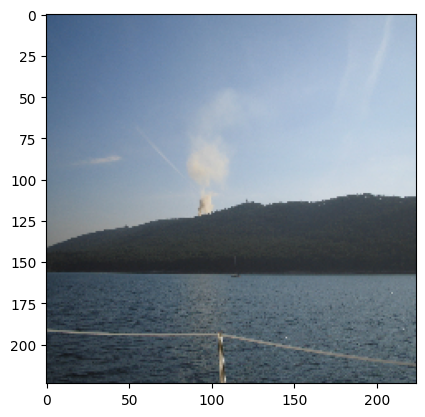

In [12]:
plt.imshow(npy_img[0]/255.)
plt.show()

### Save Numpy Files

In [13]:
np.save(sim_output_dir + '/input.npy', npy_img)
np.save(sim_output_dir + '/expected_output.npy', npy_label)

# Create Verilog Sim

In [14]:
make_verilog_simfile(
    templates_folder=template_folder, 
    build_folder=build_folder, 
)   

Input shape folded: [1, 224, 224, 3, 1]
Input stream width: 8
Input data after folded reshape: (1, 224, 224, 3, 1)
Input data packed: (1, 224, 224, 3)


# Test np.savetxt

model = ModelWrapper(build_folder + "/intermediate_models/step_create_stitched_ip.onnx")

inp_data = np.load(sim_output_dir + "/input.npy")
batchsize = inp_data.shape[0]

inp_name = model.graph.input[0].name
print(inp_name)    

inp_node = getCustomOp(model.find_consumer(inp_name))
inp_shape_folded = list(inp_node.get_folded_input_shape())

print(f'Input shape folded: {inp_shape_folded}')

inp_stream_width = inp_node.get_instream_width_padded()

print(f'Input stream width: {inp_stream_width}')

# fix first dimension (N: batch size) to correspond to input data
# since FINN model itself always uses N=1
inp_shape_folded[0] = batchsize
inp_shape_folded = tuple(inp_shape_folded)
inp_dtype = model.get_tensor_datatype(inp_name)

print(inp_shape_folded)
print(inp_dtype)

# now re-shape input data into the folded shape and do hex packing
inp_data = inp_data.reshape(inp_shape_folded)

print(f'Input data after folded reshape: {inp_data.shape}')

inp_data_packed = dpk.pack_innermost_dim_as_hex_string(
    inp_data, inp_dtype, inp_stream_width, prefix="", reverse_inner=False
)

print(f'Input data packed: {inp_data_packed.shape}')

inp_data_packed[:1, :2, :2, :3]

print(npy_img[:1, :2, :2, :3])

inp_data_packed = inp_data_packed.reshape(1, -1)

inp_data_packed.shape

# np.savetxt(sim_output_dir + "/input.dat", inp_data_packed, fmt="%s", delimiter="\n")

a = [[[3, 3], [3, 3]], [[1, 3], [3, 1]]]
a = np.array(a).astype(np.float32)

a.shape

test_a_pack = dpk.pack_innermost_dim_as_hex_string(
    a, DataType["UINT2"], 8, prefix="0x", reverse_inner=False
)

test_a_pack